
# WIRE — End-to-End: Scaling + Model Sweep


In [ ]:
``
# ==== Configuration ====
# Input engineered CSV
INPUT_CSV = "../../data/combined_wallets_with_transactions_and_balances_2.csv"  # change if needed

# Scaled outputs
OUTPUT_MINMAX   = "../../data/combined_wallets_with_transactions_and_balances_minmax.csv"
OUTPUT_STANDARD = "../../data/combined_wallets_with_transactions_and_balances_standard.csv"
OUTPUT_HYBRID   = "../../data/combined_wallets_with_transactions_and_balances_hybrid.csv"

# Persisted preprocessors
SCALER_MINMAX_PATH   = "../../models/preprocessor_minmax.pkl"
SCALER_STANDARD_PATH = "../../models/preprocessor_standard.pkl"
SCALER_HYBRID_PATH   = "../../models/preprocessor_hybrid.pkl"

# Model sweep inputs (will point to the three scaled CSVs after scaling finishes)
INPUT_SCALED_CSVS = [OUTPUT_HYBRID, OUTPUT_MINMAX, OUTPUT_STANDARD]

# Output artifacts (figures + tables)
OUT_DIR = "../../figures/model_sweep"
METRICS_CSV = f"{OUT_DIR}/metrics_summary.csv"
BANDS_CSV   = f"{OUT_DIR}/band_distributions.csv"

# Controls
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_BINS = 30
N_RELIABILITY_BINS = 15

# Toggle heavy models if runtime is a concern
ENABLE_SVM = True
ENABLE_MLP = True


In [ ]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import joblib
from time import time

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB


In [ ]:

# ==== Load ====
df = pd.read_csv(INPUT_CSV)
print("Loaded:", INPUT_CSV)
print("Rows, Cols:", df.shape)
print("\nColumns:", list(df.columns))

label_col = "isSafe" if "isSafe" in df.columns else None
raw_df = df.copy()

# ==== Feature Columns ====
all_features = [
    'noOfTrx.1', 'Balance', 'self_transfer_ratio', 'circular_txn_count',
    'circular_txn_ratio', 'avg_txn_value_eth', 'txn_spike_score',
    'value_std_dev', 'avg_gas_used', 'avg_gas_price', 'active_days',
    'wallet_age_days', 'unique_counterparties', 'failed_txn_ratio',
    'eth_inflow_outflow_ratio', 'erc20_txn_count', 'nft_txn_count',
    'first_txn_time_of_day', 'erc20_token_diversity', 'tx_direction_ratio',
    'contract_interaction_ratio', 'value_entropy', 'average_txn_interval',
    'new_token_interaction_count', 'token_approval_count',
    'sbt_poap_event_count'
]
features = [c for c in all_features if c in df.columns]
missing = [c for c in all_features if c not in df.columns]
if missing:
    print("Warning: missing columns (will be skipped):", missing)

# Ensure numeric features before any scaling
X = df[features].apply(pd.to_numeric, errors='coerce').fillna(0.0)


In [ ]:

# --- Safe numeric functions for FunctionTransformer ---
def safe_log1p(X):
    X = pd.DataFrame(X)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0.0)
    X = np.nan_to_num(X.to_numpy(dtype=float), nan=0.0, posinf=0.0, neginf=0.0)
    X = np.clip(X, 0.0, None)
    return np.log1p(X)

def hour_to_sin_cos(X):
    X = pd.DataFrame(X).apply(pd.to_numeric, errors='coerce').fillna(0.0)
    arr = np.nan_to_num(X.to_numpy(dtype=float), nan=0.0)
    arr = np.clip(arr, 0, 23)
    sin = np.sin(2*np.pi*arr/24.0)
    cos = np.cos(2*np.pi*arr/24.0)
    return np.concatenate([sin, cos], axis=1)

# Column groups
log_robust_cols = [c for c in ["Balance","noOfTrx.1","avg_txn_value_eth","value_std_dev","average_txn_interval"] if c in features]
std_cols        = [c for c in ["active_days","wallet_age_days","unique_counterparties","avg_gas_used","avg_gas_price"] if c in features]
cyc_cols        = [c for c in ["first_txn_time_of_day"] if c in features]
cyc_and_scaled  = set(log_robust_cols + std_cols + cyc_cols)
passthrough_cols = [c for c in features if c not in cyc_and_scaled]

log_then_robust = Pipeline([
    ("log", FunctionTransformer(safe_log1p, validate=False)),
    ("robust", RobustScaler())
])
cyclical = FunctionTransformer(hour_to_sin_cos, validate=False)

# Three preprocessors
pre_minmax = ColumnTransformer([("mm", MinMaxScaler(), features)], remainder="drop")
pre_standard = ColumnTransformer([("std", StandardScaler(), features)], remainder="drop")
pre_hybrid = ColumnTransformer(
    transformers=[
        ("log_robust", log_then_robust, log_robust_cols),
        ("standard", StandardScaler(), std_cols),
        ("cyclical", cyclical, cyc_cols),
        ("passthrough", "passthrough", passthrough_cols),
    ],
    remainder="drop"
)

print("Hybrid groups:")
print("  log+robust:", log_robust_cols)
print("  standard  :", std_cols)
print("  cyclical  :", cyc_cols, "-> (sin, cos)")
print("  passthrough:", passthrough_cols)


In [ ]:

from pathlib import Path

def fit_transform_and_export(preprocessor, X, base_df, out_csv, scaler_path):
    Xt = preprocessor.fit_transform(X)

    # Clean names: remove prefixes; map cyclical to _sin/_cos
    try:
        raw_names = list(preprocessor.get_feature_names_out())
        out_cols = []
        for n in raw_names:
            if n.startswith("cyclical__first_txn_time_of_day"):
                out_cols.append("first_txn_time_of_day_sin" if n.endswith("0") else "first_txn_time_of_day_cos")
            else:
                out_cols.append(n.split("__")[-1])
    except Exception:
        out_cols = [f"f_{i}" for i in range(np.asarray(Xt).shape[1])]

    Xt_df = pd.DataFrame(Xt, index=base_df.index, columns=out_cols)

    out = pd.concat(
        [base_df.drop(columns=[c for c in features if c in base_df.columns], errors="ignore"), Xt_df],
        axis=1
    )

    Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
    Path(scaler_path).parent.mkdir(parents=True, exist_ok=True)

    out.to_csv(out_csv, index=False)
    joblib.dump(preprocessor, scaler_path)

    print(f"Saved scaled CSV -> {out_csv}")
    print(f"Saved fitted preprocessor -> {scaler_path}")
    return out


In [ ]:

print("\n=== Fitting All-MinMax ===")
out_minmax = fit_transform_and_export(pre_minmax, X, raw_df, OUTPUT_MINMAX, SCALER_MINMAX_PATH)

print("\n=== Fitting All-Standard ===")
out_standard = fit_transform_and_export(pre_standard, X, raw_df, OUTPUT_STANDARD, SCALER_STANDARD_PATH)

print("\n=== Fitting HYBRID (recommended) ===")
out_hybrid = fit_transform_and_export(pre_hybrid, X, raw_df, OUTPUT_HYBRID, SCALER_HYBRID_PATH)


In [ ]:

def hist_for_feature(df, base_name, bins=30, title=""):
    candidates = [c for c in df.columns if c.split("__")[-1] == base_name or base_name in c]
    col = None
    for c in candidates:
        if pd.api.types.is_numeric_dtype(df[c]):
            col = c; break
    if col is None:
        print(f"[warn] {base_name} not found in df"); return
    plt.hist(df[col].astype(float), bins=bins); plt.title(title or col)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); hist_for_feature(out_minmax,  "Balance", title="Balance (MinMax)")
plt.subplot(1,3,2); hist_for_feature(out_standard,"Balance", title="Balance (Standard)")
plt.subplot(1,3,3); hist_for_feature(out_hybrid,  "Balance", title="Balance (Hybrid)")
plt.tight_layout(); plt.show()


## Model Sweep (Calibrated, per Scaled CSV)

In [ ]:

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

def build_models(random_state=42):
    models = {
        "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=random_state),
        "RF": RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=-1, random_state=random_state, class_weight="balanced"),
        "GB": GradientBoostingClassifier(random_state=random_state),
        "KNN": KNeighborsClassifier(),
        "NB": GaussianNB(),
    }
    if ENABLE_SVM:
        models["SVM"] = SVC(kernel="rbf", probability=True, random_state=random_state, class_weight="balanced")
    if ENABLE_MLP:
        models["MLP"] = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500, random_state=random_state)
    return models

def reliability_curve(y_true, y_prob, n_bins=15):
    bins = np.linspace(0,1,n_bins+1)
    ids = np.digitize(y_prob, bins) - 1
    xs, ys, ws = [], [], []
    for b in range(n_bins):
        m = (ids==b)
        if m.sum()==0: 
            continue
        xs.append(y_prob[m].mean())
        ys.append(y_true[m].mean())
        ws.append(m.mean())
    return np.array(xs), np.array(ys), np.array(ws)

def expected_calibration_error(y_true, y_prob, n_bins=15):
    mp, fp, w = reliability_curve(y_true, y_prob, n_bins)
    return float(np.sum(w * np.abs(fp - mp)))

def band_distribution(scores_0_1):
    s = scores_0_1
    bins = [0, .2, .4, .6, .8, 1.0000001]
    labels = ["0–20", "20–40", "40–60", "60–80", "80–100"]
    idx = np.digitize(s, bins) - 1
    counts = [int((idx==i).sum()) for i in range(5)]
    fracs = [float(c)/len(s) if len(s) else 0.0 for i, c in enumerate(counts)]
    return labels, counts, fracs


In [ ]:

metrics_all = []
bands_all = []

for csv_path in INPUT_SCALED_CSVS:
    print(f"\n===== DATASET: {csv_path} =====")
    df_sc = pd.read_csv(csv_path)
    if "isSafe" not in df_sc.columns:
        raise ValueError(f"isSafe not in {csv_path}")
    y = df_sc["isSafe"].astype(int)

    # Features: numeric only; remove obvious non-features
    exclude = set(["isSafe", "Address", "Name", "Tags", "Transactions"])
    Xs = df_sc.drop(columns=[c for c in exclude if c in df_sc.columns], errors="ignore")
    Xs = Xs.select_dtypes(include=[np.number]).fillna(0.0)

    X_train, X_test, y_train, y_test = train_test_split(
        Xs, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )
    print("Train/Test:", X_train.shape, X_test.shape)

    models = build_models(RANDOM_STATE)

    # Multi-panel figs
    n = len(models)
    cols = 3
    rows = int(np.ceil(n/cols))
    fig_hist, axes_hist = plt.subplots(rows, cols, figsize=(15, 4*rows))
    fig_rel, axes_rel = plt.subplots(rows, cols, figsize=(15, 4*rows))

    for i, (name, base_model) in enumerate(models.items()):
        print(f"--- Model: {name}")
        t0 = time()
        # Calibrate with isotonic; fallback to sigmoid
        try:
            clf = CalibratedClassifierCV(base_model, method="isotonic", cv=5)
            clf.fit(X_train, y_train)
        except Exception as e:
            print("Isotonic failed -> sigmoid:", e)
            clf = CalibratedClassifierCV(base_model, method="sigmoid", cv=5)
            clf.fit(X_train, y_train)

        y_prob = clf.predict_proba(X_test)[:,1]
        y_pred = (y_prob >= 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred)
        f1  = f1_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_prob)
        ap  = average_precision_score(y_test, y_prob)
        bri = brier_score_loss(y_test, y_prob)
        ece = expected_calibration_error(y_test.values, y_prob, n_bins=N_RELIABILITY_BINS)

        # best F1 threshold
        thresholds = np.linspace(0,1,101)
        f1s = [f1_score(y_test, (y_prob>=t).astype(int)) for t in thresholds]
        best_t_idx = int(np.argmax(f1s))
        best_t = thresholds[best_t_idx]
        best_f1 = f1s[best_t_idx]

        metrics_all.append({
            "Dataset": Path(csv_path).name,
            "Model": name,
            "ROC_AUC": round(roc, 4),
            "AvgPrecision": round(ap, 4),
            "Accuracy@0.5": round(acc, 4),
            "F1@0.5": round(f1, 4),
            "F1@bestT": round(best_f1, 4),
            "BestT": round(float(best_t), 3),
            "Brier": round(bri, 4),
            "ECE": round(ece, 4),
            "TrainTimeSec": round(time()-t0, 1),
            "N_train": int(len(X_train)),
            "N_test": int(len(X_test)),
        })

        labels, counts, fracs = band_distribution(y_prob)
        for lab, c, f in zip(labels, counts, fracs):
            bands_all.append({
                "Dataset": Path(csv_path).name, "Model": name,
                "Band": lab, "Count": c, "Frac": round(f, 4)
            })

        # Plots
        r, c = divmod(i, cols)
        axh = axes_hist[r, c] if rows>1 else axes_hist[c] if n>1 else axes_hist
        axr = axes_rel[r, c]  if rows>1 else axes_rel[c]  if n>1 else axes_rel

        axh.hist((y_prob*100).round(2), bins=N_BINS, alpha=0.9)
        axh.set_title(f"{name} — Scores (0–100)")
        axh.set_xlabel("Score"); axh.set_ylabel("Count")

        mp, fp, _ = reliability_curve(y_test.values, y_prob, n_bins=N_RELIABILITY_BINS)
        axr.plot([0,1],[0,1],'--',color='gray', label='Ideal')
        axr.plot(mp, fp, marker='o', label=f"ECE={ece:.3f}")
        axr.set_title(f"{name} — Reliability")
        axr.set_xlabel("Mean predicted"); axr.set_ylabel("Fraction positive")
        axr.legend()

    fig_hist.suptitle(f"Figure 7 — Histograms ({Path(csv_path).name})", y=0.995)
    fig_rel.suptitle(f"Reliability Curves ({Path(csv_path).name})", y=0.995)
    fig_hist.tight_layout(); fig_rel.tight_layout()

    out_hist = f"{OUT_DIR}/figure7_histograms_{Path(csv_path).stem}.png"
    out_rel  = f"{OUT_DIR}/reliability_{Path(csv_path).stem}.png"
    Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
    fig_hist.savefig(out_hist, dpi=200)
    fig_rel.savefig(out_rel, dpi=200)
    plt.close(fig_hist); plt.close(fig_rel)

    print("Saved:", out_hist)
    print("Saved:", out_rel)

# Save aggregate tables
metrics_df = pd.DataFrame(metrics_all).sort_values(by=["Dataset","ROC_AUC"], ascending=[True, False])
bands_df = pd.DataFrame(bands_all)

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
metrics_df.to_csv(METRICS_CSV, index=False)
bands_df.to_csv(BANDS_CSV, index=False)

print("\nSaved metrics ->", METRICS_CSV)
print("Saved band distributions ->", BANDS_CSV)


In [ ]:
from IPython.display import Image, display

display(Image(filename="../../figures/model_sweep/figure7_histograms_combined_wallets_with_transactions_and_balances_hybrid.png"))
display(Image(filename="../../figures/model_sweep/reliability_combined_wallets_with_transactions_and_balances_hybrid.png"))

In [ ]:
display(Image(filename="../../figures/model_sweep/figure7_histograms_combined_wallets_with_transactions_and_balances_minmax.png"))
display(Image(filename="../../figures/model_sweep/reliability_combined_wallets_with_transactions_and_balances_minmax.png"))

In [ ]:
display(Image(filename="../../figures/model_sweep/figure7_histograms_combined_wallets_with_transactions_and_balances_standard.png"))
display(Image(filename="../../figures/model_sweep/reliability_combined_wallets_with_transactions_and_balances_standard.png"))

### Final Candidate (V1): Hybrid Scaling + Calibrated Gradient Boosting

In [ ]:
import json, time
from dataclasses import asdict, dataclass

from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    brier_score_loss
)

FINAL_PIPELINE_PATH = "../../models/wire_trust_pipeline_v1.pkl"
FINAL_MODEL_CARD     = "../../models/wire_trust_model_card_v1.json"

# --- Helper: reliability / ECE (same as earlier)
def reliability_curve(y_true, y_prob, n_bins=15):
    bins = np.linspace(0,1,n_bins+1)
    ids = np.digitize(y_prob, bins) - 1
    xs, ys, ws = [], [], []
    for b in range(n_bins):
        m = (ids==b)
        if m.sum()==0: 
            continue
        xs.append(y_prob[m].mean())
        ys.append(y_true[m].mean())
        ws.append(m.mean())
    return np.array(xs), np.array(ys), np.array(ws)

def expected_calibration_error(y_true, y_prob, n_bins=15):
    mp, fp, w = reliability_curve(y_true, y_prob, n_bins)
    return float(np.sum(w * np.abs(fp - mp)))

# --- Choose base model
USE_GRADIENT_BOOSTING = True  # set False to use RandomForest instead
USE_LOGREG = True

# if USE_GRADIENT_BOOSTING:
#     base_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
#     model_name = "GB+Isotonic"
# else:
#     base_model = RandomForestClassifier(
#         n_estimators=400, n_jobs=-1, class_weight="balanced", random_state=RANDOM_STATE
#     )
#     model_name = "RF+Isotonic"

if USE_LOGREG:
    base_model = LogisticRegression(
        max_iter=2000, class_weight="balanced", C=1.0, penalty="l2",
        solver="lbfgs", random_state=RANDOM_STATE
    )
    model_name = "LogReg+Isotonic"
else:
    base_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
    model_name = "GB+Isotonic"

# --- Calibrated classifier
calibrated = CalibratedClassifierCV(base_model, method="isotonic", cv=5)

# --- End-to-end pipeline: Hybrid preprocessor (defined earlier) + calibrated model
final_pipe = Pipeline([
    ("pre", pre_hybrid),      # uses safe_log1p + Robust + Std + cyclical
    ("clf", calibrated)
])

# --- Train/test split on RAW engineered features (pipeline handles scaling internally)
y_all = df["isSafe"].astype(int)
X_all = df[features].apply(pd.to_numeric, errors="coerce").fillna(0.0)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, stratify=y_all, random_state=RANDOM_STATE
)

print(f"Training final pipeline: {model_name}")
t0 = time.time()
final_pipe.fit(X_tr, y_tr)
train_secs = round(time.time() - t0, 1)
print("Fit time (sec):", train_secs)

# --- Evaluate
y_prob = final_pipe.predict_proba(X_te)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

roc  = roc_auc_score(y_te, y_prob)
ap   = average_precision_score(y_te, y_prob)
acc  = accuracy_score(y_te, y_pred)
f1d  = f1_score(y_te, y_pred)
bri  = brier_score_loss(y_te, y_prob)
ece  = expected_calibration_error(y_te.values, y_prob, n_bins=15)

# best-threshold by F1
ths = np.linspace(0,1,101)
f1s = [f1_score(y_te, (y_prob>=t).astype(int)) for t in ths]
best_idx = int(np.argmax(f1s))
best_t = float(ths[best_idx])
best_f1 = float(f1s[best_idx])

print(f"\n[Final V1: {model_name}]")
print(f"ROC-AUC: {roc:.4f} | AP: {ap:.4f} | Acc@0.5: {acc:.4f} | F1@0.5: {f1d:.4f}")
print(f"Brier: {bri:.4f} | ECE: {ece:.4f} | F1@bestT={best_f1:.4f} (T={best_t:.2f})")

# --- Persist one-file pipeline (serving-ready)
Path(FINAL_PIPELINE_PATH).parent.mkdir(parents=True, exist_ok=True)
joblib.dump(final_pipe, FINAL_PIPELINE_PATH)
print("Saved final pipeline ->", FINAL_PIPELINE_PATH)

# --- Save a tiny model card (metadata + best threshold)
model_card = {
    "name": "WIRE Trust Score — Final V1",
    "pipeline": model_name,
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "random_state": RANDOM_STATE,
    "features": features,
    "metrics": {
        "roc_auc": round(float(roc), 4),
        "avg_precision": round(float(ap), 4),
        "accuracy@0.5": round(float(acc), 4),
        "f1@0.5": round(float(f1d), 4),
        "brier": round(float(bri), 4),
        "ece": round(float(ece), 4),
        "best_f1": round(best_f1, 4),
        "best_threshold": round(best_t, 3)
    },
    "train_time_sec": train_secs
}
with open(FINAL_MODEL_CARD, "w") as f:
    json.dump(model_card, f, indent=2)
print("Saved model card ->", FINAL_MODEL_CARD)

# --- Inference helper (FICO 0–100)
def wire_trust_score(row_or_dict):
    """
    Compute FICO-like 0–100 trust score from a single wallet feature row/dict.
    Expects *raw engineered* feature values; pipeline scales internally.
    """
    if isinstance(row_or_dict, dict):
        row = {k: row_or_dict.get(k, 0.0) for k in features}
        X_one = pd.DataFrame([row])
    else:  # assume pandas Series/DataFrame row
        X_one = pd.DataFrame([row_or_dict.reindex(features).fillna(0.0)])
    prob = final_pipe.predict_proba(X_one)[:, 1][0]
    return float(np.clip(prob * 100.0, 0.0, 100.0))


# Demo (optional): score the first test row
demo_score = wire_trust_score(X_te.iloc[0])
print(f"Demo FICO-like score (0–100): {demo_score:.2f}")

### Visualizations

In [ ]:
import os, glob, json, time, joblib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score, roc_auc_score,
    average_precision_score, brier_score_loss
)
from sklearn.model_selection import train_test_split
from matplotlib.table import Table

# ---------- custom functions must exist BEFORE joblib.load ----------
def safe_log1p(X):
    import numpy as _np, pandas as _pd
    X = _pd.DataFrame(X).apply(_pd.to_numeric, errors='coerce').fillna(0.0)
    arr = _np.nan_to_num(X.to_numpy(dtype=float), nan=0.0, posinf=0.0, neginf=0.0)
    arr = _np.clip(arr, 0.0, None)
    return _np.log1p(arr)

def hour_to_sin_cos(X):
    import numpy as _np, pandas as _pd
    X = _pd.DataFrame(X).apply(_pd.to_numeric, errors='coerce').fillna(0.0)
    arr = _np.nan_to_num(X.to_numpy(dtype=float), nan=0.0)
    arr = _np.clip(arr, 0, 23)
    sin = _np.sin(2*_np.pi*arr/24.0)
    cos = _np.cos(2*_np.pi*arr/24.0)
    return _np.concatenate([sin, cos], axis=1)

# ---------- paths / config ----------
FINAL_DIR = Path("../../figures/final"); FINAL_DIR.mkdir(parents=True, exist_ok=True)
SWEEP_METRICS = Path("../../figures/model_sweep/metrics_summary.csv")
FINAL_PIPELINE_PATH = Path("../../models/wire_trust_pipeline_v1.pkl")
RANDOM_STATE = 42
TEST_SIZE = 0.20

# ---------- helpers ----------
def load_engineered_df():
    cand = [
        "../../data/combined_wallets_with_transactions_and_balances_3.csv",
        "../../data/combined_wallets_with_transactions_and_balances_2.csv",
        "../../data/combined_wallets_with_transactions_and_balances.csv",
    ]
    files = [p for p in cand if Path(p).exists()]
    if not files:
        g = sorted(glob.glob("../../data/combined_wallets_with_transactions_and_balances*.*"))
        if not g:
            raise FileNotFoundError("Engineered CSV not found under ../../data/")
        files = [g[-1]]
    print("Using engineered CSV:", files[0])
    return pd.read_csv(files[0])

def reliability_curve(y_true, y_prob, n_bins=15):
    bins = np.linspace(0,1,n_bins+1)
    ids = np.digitize(y_prob, bins) - 1
    xs, ys, ws = [], [], []
    for b in range(n_bins):
        m = (ids==b)
        if m.sum()==0: 
            continue
        xs.append(y_prob[m].mean()); ys.append(y_true[m].mean()); ws.append(m.mean())
    return np.array(xs), np.array(ys), np.array(ws)

def expected_calibration_error(y_true, y_prob, n_bins=15):
    mp, fp, w = reliability_curve(y_true, y_prob, n_bins)
    return float(np.sum(w * np.abs(fp - mp)))

# ---------- ensure predictions exist ----------
need_preds = any(v not in globals() for v in ["y_prob", "y_pred", "X_te", "y_te", "X_all", "y_all"])
if need_preds:
    print("[info] rebuilding predictions with final pipeline…")
    if not FINAL_PIPELINE_PATH.exists():
        raise FileNotFoundError(f"Final pipeline not found at {FINAL_PIPELINE_PATH}. Train & save it first.")
    final_pipe = joblib.load(FINAL_PIPELINE_PATH)

    df_eng = load_engineered_df()
    if "isSafe" not in df_eng.columns:
        raise ValueError("'isSafe' not found in engineered CSV.")

    y_all = df_eng["isSafe"].astype(int).values
    X_all = df_eng.select_dtypes(include=[np.number]).drop(columns=["isSafe"], errors="ignore").fillna(0.0)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_all, y_all, test_size=TEST_SIZE, stratify=y_all, random_state=RANDOM_STATE
    )
    y_prob = final_pipe.predict_proba(X_te)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

print(f"[sizes] total={len(y_all):,}  train={len(X_tr):,}  test={len(X_te):,}")

# ---------- metrics ----------
roc  = roc_auc_score(y_te, y_prob)
ap   = average_precision_score(y_te, y_prob)
acc  = accuracy_score(y_te, y_pred)
f1d  = f1_score(y_te, y_pred)
bri  = brier_score_loss(y_te, y_prob)
ece  = expected_calibration_error(y_te, y_prob, n_bins=15)
ths = np.linspace(0,1,101)
f1s = [f1_score(y_te, (y_prob>=t).astype(int)) for t in ths]
best_idx = int(np.argmax(f1s)); best_t = float(ths[best_idx]); best_f1 = float(f1s[best_idx])

# ---------- 1) Model Comparison (HYBRID only) ----------
if 'metrics_df' not in globals():
    if not SWEEP_METRICS.exists():
        raise FileNotFoundError(f"Model sweep metrics not found at {SWEEP_METRICS}. Run the sweep first.")
    metrics_df = pd.read_csv(SWEEP_METRICS)

hybrid_name = "combined_wallets_with_transactions_and_balances_hybrid.csv"
mdf = metrics_df[metrics_df["Dataset"] == hybrid_name].copy()
desired = ["GB","RF","LogReg","SVM","KNN","MLP","NB"]
present = [m for m in desired if m in mdf["Model"].unique()]
mdf["Model"] = pd.Categorical(mdf["Model"], categories=present, ordered=True)
best = mdf.loc[mdf.groupby("Model", observed=True)["ROC_AUC"].idxmax()].sort_values("Model")

fig, ax = plt.subplots(figsize=(11,6))
barw = 0.25; x = np.arange(len(best))
ax.bar(x - barw, best["Accuracy@0.5"].astype(float), width=barw, label="Accuracy@0.5")
ax.bar(x,          best["F1@0.5"].astype(float),     width=barw, label="F1@0.5")
ax.bar(x + barw,   best["ROC_AUC"].astype(float),    width=barw, label="ROC-AUC")
ax.set_xticks(x); ax.set_xticklabels(best["Model"]); ax.set_ylim(0,1.05)
ax.set_title("Model Performance Comparison — HYBRID Scaling")
ax.set_ylabel("Score"); ax.grid(axis='y', alpha=.25); ax.legend()
out1 = FINAL_DIR / "model_performance_comparison_hybrid.png"
plt.tight_layout(); plt.savefig(out1, dpi=200); plt.show()
print("Saved:", out1)

# ---------- 2) Trust Score Distributions: Test vs Full ----------
scores_test = np.clip(y_prob * 100.0, 0, 100)
y_prob_full = joblib.load(FINAL_PIPELINE_PATH).predict_proba(X_all)[:,1]  # fresh to avoid any mutation
scores_full = np.clip(y_prob_full * 100.0, 0, 100)

fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
sns.histplot(scores_test, bins=40, kde=True, color="#7bc77b", ax=axes[0])
for v in [20,40,60,80]: axes[0].axvline(v, color="#999", ls="--", lw=1)
axes[0].set_title(f"Trust Scores — Test (n={len(scores_test):,})")
axes[0].set_xlabel("Trust Score"); axes[0].set_ylabel("Wallet Count")

sns.histplot(scores_full, bins=40, kde=True, color="#6aa6f8", ax=axes[1])
for v in [20,40,60,80]: axes[1].axvline(v, color="#999", ls="--", lw=1)
axes[1].set_title(f"Trust Scores — Full Dataset (n={len(scores_full):,})")
axes[1].set_xlabel("Trust Score")

plt.suptitle("Final Trust Score Distribution — Test vs Full", y=1.02)
out2a = FINAL_DIR / "final_trust_score_distribution_test_vs_full.png"
plt.tight_layout(); plt.savefig(out2a, dpi=200); plt.show()
print("Saved:", out2a)

# also keep your original single test histogram if you want that slide:
plt.figure(figsize=(10,5))
sns.histplot(scores_test, bins=40, kde=True, color="#7bc77b")
for v in [20,40,60,80]: plt.axvline(v, color="#999", ls="--", lw=1)
plt.title("Final Trust Score Distribution — Test Set (0–100)")
plt.xlabel("Trust Score"); plt.ylabel("Wallet Count")
out2 = FINAL_DIR / "final_trust_score_distribution.png"
plt.tight_layout(); plt.savefig(out2, dpi=200); plt.show()
print("Saved:", out2)

# ---------- 3) Confusion Matrix + FPR/FNR ----------
cm = confusion_matrix(y_te, (scores_test>=50).astype(int), labels=[0,1])  # threshold view
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn + 1e-9); fnr = fn / (fn + tp + 1e-9)

fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(1,2, width_ratios=[2,1], wspace=.25)
ax1 = fig.add_subplot(gs[0,0])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: Mal(0)","Pred: Safe(1)"],
            yticklabels=["Actual: Mal(0)","Actual: Safe(1)"],
            cbar=False, ax=ax1)
ax1.set_title("Confusion Matrix (Final Model)")

ax2 = fig.add_subplot(gs[0,1]); ax2.axis("off")
ax2.text(0.02, 0.98,
         (f"Samples (test): {len(y_te):,}\n\n"
          f"TN: {tn:,}   FP: {fp:,}\nFN: {fn:,}   TP: {tp:,}\n\n"
          f"FPR = FP/(FP+TN) = {fpr:.3%}\n"
          f"FNR = FN/(FN+TP) = {fnr:.3%}\n\n"
          f"In blockchain risk, we usually minimize FNR "
          f"(missed malicious) even if FPR rises slightly."),
         va="top", fontsize=12)
plt.suptitle("Model Analysis — Final Calibrated Pipeline", y=1.02)
out3 = FINAL_DIR / "model_analysis_confusion_fpr_fnr.png"
plt.tight_layout(); plt.savefig(out3, dpi=200, bbox_inches="tight"); plt.show()
print("Saved:", out3)

# ---------- 4) Compact Metrics Table ----------
roc  = roc_auc_score(y_te, y_prob)
ap   = average_precision_score(y_te, y_prob)
acc  = accuracy_score(y_te, (scores_test>=50).astype(int))
f1d  = f1_score(y_te, (scores_test>=50).astype(int))
bri  = brier_score_loss(y_te, y_prob)
ece  = expected_calibration_error(y_te, y_prob, n_bins=15)

final_metrics = {
    "ROC-AUC": roc, "Avg Precision": ap, "Accuracy@50": acc, "F1@50": f1d,
    "Brier": bri, "ECE": ece, "Best F1": float(np.max(f1s)), "Best Threshold": float(ths[int(np.argmax(f1s))])
}
keys = list(final_metrics.keys()); vals = [f"{final_metrics[k]:.4f}" for k in keys]

fig, ax = plt.subplots(figsize=(6.8, 3.8)); ax.axis('off')
tbl = Table(ax, bbox=[0,0,1,1])
n = len(keys); cell_w = 0.5; cell_h = 1.0/(n+1)
tbl.add_cell(0,0, cell_w, cell_h, text="Metric", loc='center', facecolor="#f0f0f0")
tbl.add_cell(0,1, cell_w, cell_h, text="Value",  loc='center', facecolor="#f0f0f0")
for i,(k,v) in enumerate(zip(keys, vals), start=1):
    tbl.add_cell(i,0, cell_w, cell_h, text=k, loc='left')
    tbl.add_cell(i,1, cell_w, cell_h, text=v, loc='center')
ax.add_table(tbl); ax.set_title("Final Model — Metrics Summary", pad=8)
out4 = FINAL_DIR / "final_metrics_table.png"
plt.savefig(out4, dpi=200, bbox_inches="tight"); plt.show()
print("Saved:", out4)

[base rate] safe fraction = 0.768  -> OddsScore midpoint anchored at 50


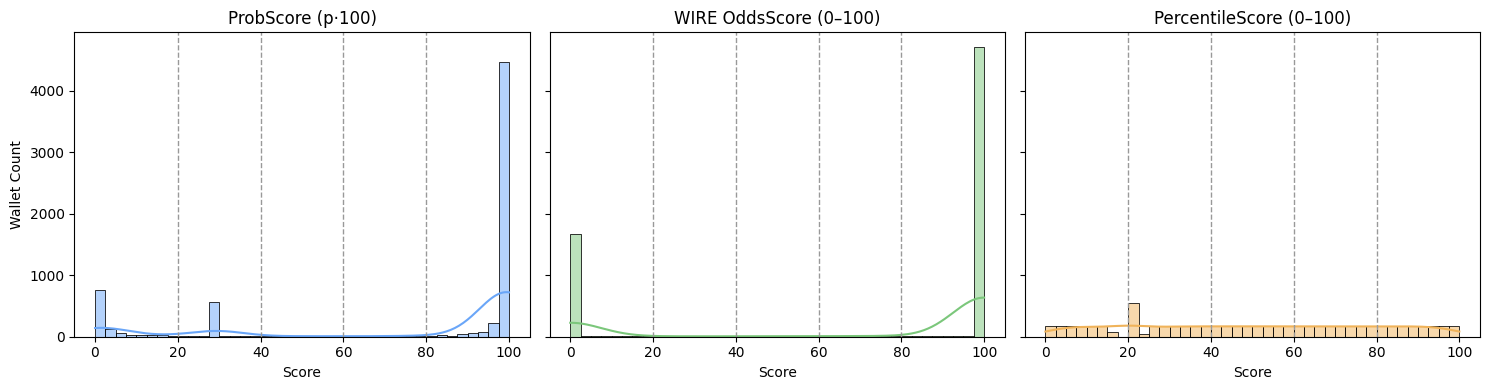

Saved: ../../figures/final/score_design/score_design_prob_vs_odds_vs_percentile.png


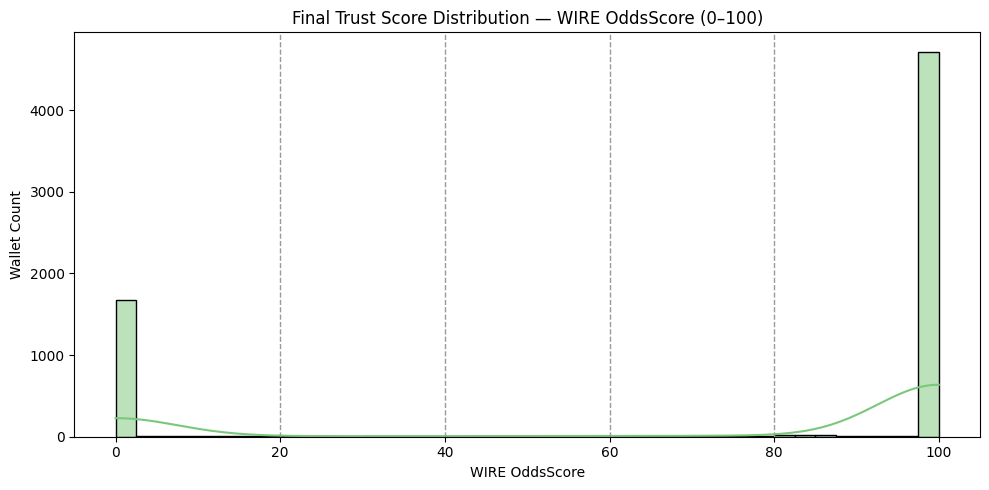

Saved: ../../figures/final/score_design/final_trust_score_distribution_wire_odds.png

[band distribution on OddsScore]
0–20        59
20–40       52
40–60       66
60–80       84
80–100    4817


In [19]:
# ============================
# WIRE score mapping: Probability -> FICO-like OddsScore + PercentileScore
# ============================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from scipy.stats import rankdata

FIX_DIR = Path("../../figures/final/score_design"); FIX_DIR.mkdir(parents=True, exist_ok=True)

# --- pick the probability series to score ---
# Use the smoother, well-calibrated variant from your diagnostics.
# If you didn't run that cell, fall back to y_prob.
p_best = globals().get("p_smooth", globals().get("y_prob"))
assert p_best is not None, "No probability vector found. Run the final pipeline inference first."

# --- base rate (used to anchor log-odds) ---
base = float((y_all == 1).mean())  # prevalence of 'safe'
eps = 1e-9

def wire_odds_score(p, base_rate=base, midpoint=50.0, points_to_double_odds=20.0):
    """
    Map calibrated probability of SAFE -> 0..100 FICO-like score.
    - Center at dataset base rate (so typical wallets sit near 'midpoint').
    - Points-to-double-odds controls slope (FICO analogy).
    """
    p = np.clip(np.asarray(p, dtype=float), eps, 1.0 - eps)
    # log-odds relative to base rate
    logodds = np.log(p / (1.0 - p))
    logodds0 = np.log(base_rate / (1.0 - base_rate))
    B = points_to_double_odds / np.log(2.0)     # points per ln(2) increase in odds
    score = midpoint + B * (logodds - logodds0) # shift relative to base
    return np.clip(score, 0.0, 100.0)

def percentile_score(p):
    """Monotonic rank-based 0..100 score for banding/UX (not a probability)."""
    r = rankdata(p, method="average") / len(p)
    return (r * 100.0).astype(float)

# --- compute scores
prob_score = np.clip(p_best * 100.0, 0, 100)             # what you plotted before
odds_score = wire_odds_score(p_best, base_rate=base)      # FICO-like, compressed extremes
pct_score  = percentile_score(p_best)                     # uniform by construction

print(f"[base rate] safe fraction = {base:.3f}  -> OddsScore midpoint anchored at 50")

# --- side-by-side comparison for slides
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, data, title, color in [
    (axes[0], prob_score, "ProbScore (p·100)", "#6aa6f8"),
    (axes[1], odds_score, "WIRE OddsScore (0–100)", "#7bc77b"),
    (axes[2], pct_score,  "PercentileScore (0–100)", "#f0b35a"),
]:
    sns.histplot(data, bins=40, kde=True, ax=ax, color=color)
    for v in [20,40,60,80]: ax.axvline(v, color="#999", ls="--", lw=1)
    ax.set_title(title); ax.set_xlabel("Score"); ax.set_ylabel("Wallet Count")
plt.tight_layout()
out_grid = FIX_DIR / "score_design_prob_vs_odds_vs_percentile.png"
plt.savefig(out_grid, dpi=200); plt.show()
print("Saved:", out_grid)

# --- focused single-plot for your “final curve” slide (use OddsScore)
plt.figure(figsize=(10,5))
sns.histplot(odds_score, bins=40, kde=True, color="#7bc77b")
for v in [20,40,60,80]: plt.axvline(v, color="#999", ls="--", lw=1)
plt.title("Final Trust Score Distribution — WIRE OddsScore (0–100)")
plt.xlabel("WIRE OddsScore"); plt.ylabel("Wallet Count")
out_single = FIX_DIR / "final_trust_score_distribution_wire_odds.png"
plt.tight_layout(); plt.savefig(out_single, dpi=200); plt.show()
print("Saved:", out_single)

# --- (optional) show how banding improves UX segmentation
bands = pd.cut(odds_score, bins=[0,20,40,60,80,100], labels=["0–20","20–40","40–60","60–80","80–100"])
band_counts = bands.value_counts().sort_index()
print("\n[band distribution on OddsScore]")
print(band_counts.to_string())
